# Time series analysis techniques

This notebook explores the various techniques for analysing time series.

## Setup

In [1]:
import pandas as ps
import numpy as np
import keras
from pandas.tools.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

Using Theano backend.
/Users/willem/dev/ml/keras/keras/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


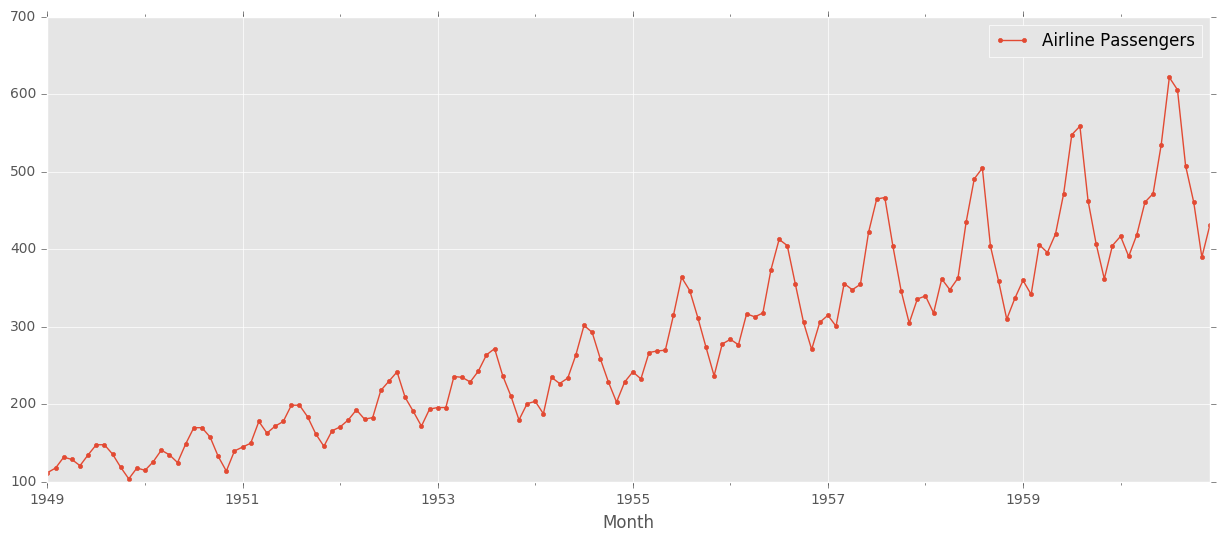

In [2]:
ap = ps.read_excel('international-airline-passengers.xls', skiprows=14)
ap.columns = [["Month", "Passengers"]]
apts = ps.Series(ap.Passengers.values, index=ap.Month)
ax = apts.plot(marker='.', label='Airline Passengers')
ax.legend()

## Plotting trends

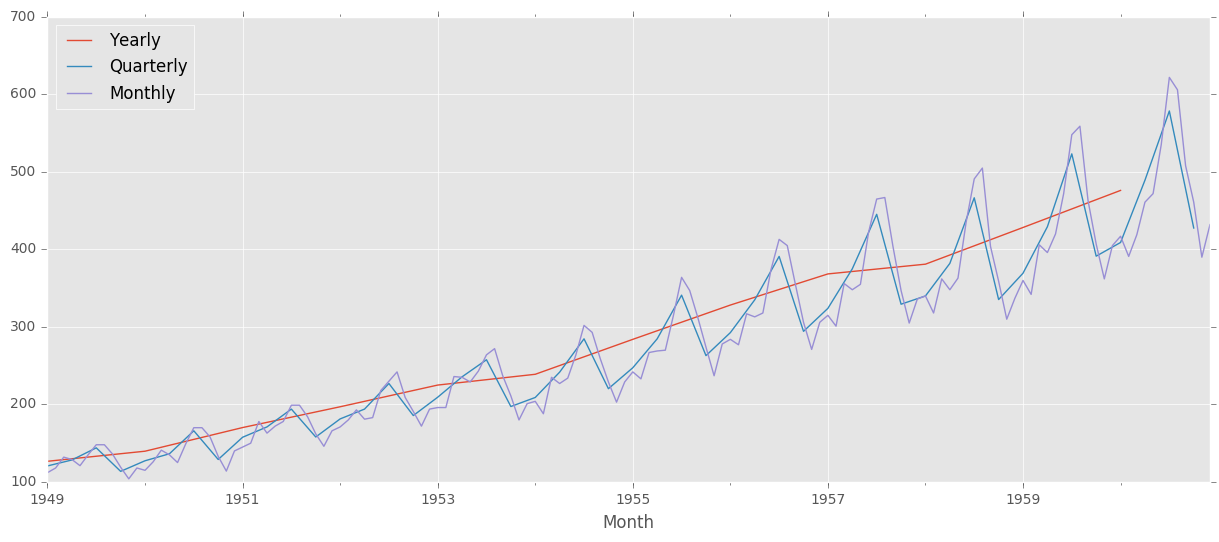

In [208]:
#let's look at the various trends
yearly = apts.resample('A').mean()
quarterly = apts.resample('Q').mean()
monthly = apts.resample('M').mean()
yearly.plot(label='Yearly')
quarterly.plot(label='Quarterly')
ax = monthly.plot(label='Monthly')
ax.legend(loc='best')

## Exploratory analysis

In [127]:
#Check some properties
apts.autocorr()

0.96019464804985255

This series is obviously highly autocorrelating. For additional theoretical information:
https://en.wikipedia.org/wiki/Autocorrelation

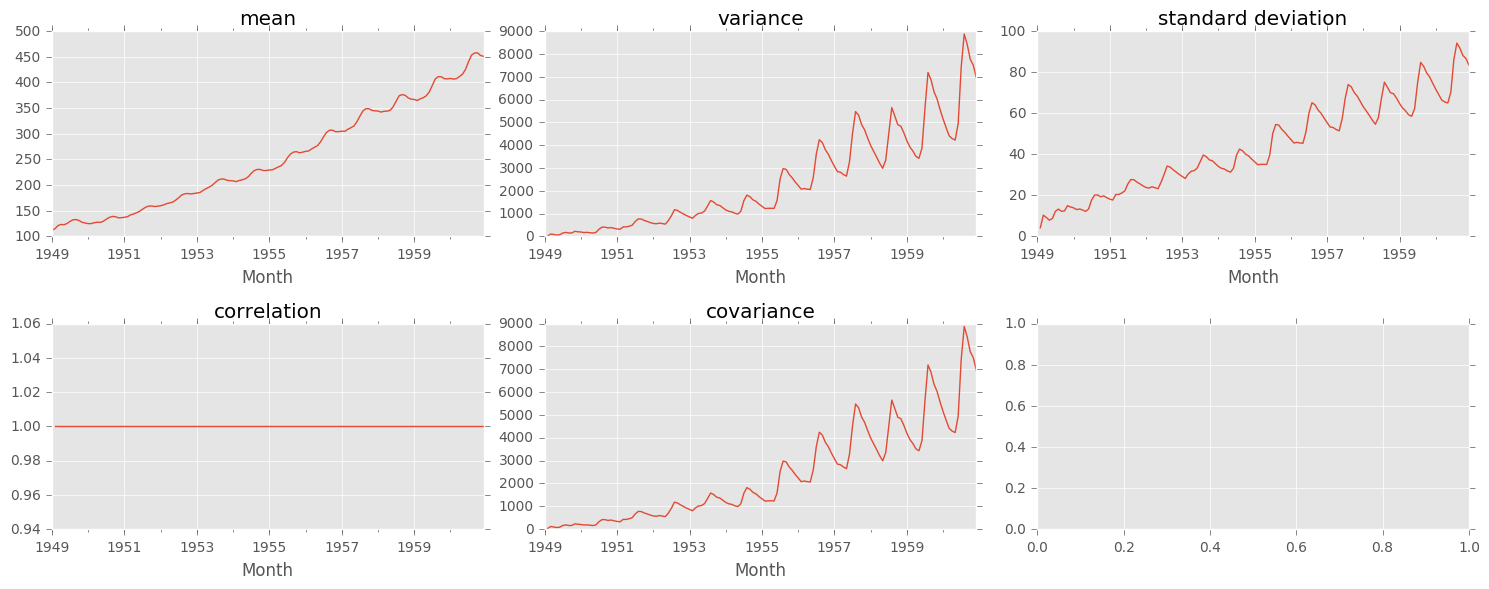

In [142]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6));

#exponential weighted function analysis
span_value = 25
apts.ewm(span=span_value).mean().plot(title = 'mean', ax = axes[0][0])
apts.ewm(span=span_value).var().plot(title='variance', ax = axes[0][1])
apts.ewm(span=span_value).std().plot(title='standard deviation', ax = axes[0][2])
apts.ewm(span=span_value).corr().plot(title='correlation', ax = axes[1][0])
apts.ewm(span=span_value).cov().plot(title='covariance', ax = axes[1][1])
plt.tight_layout()

EWM is used to provide functions over exponentially expanding windows

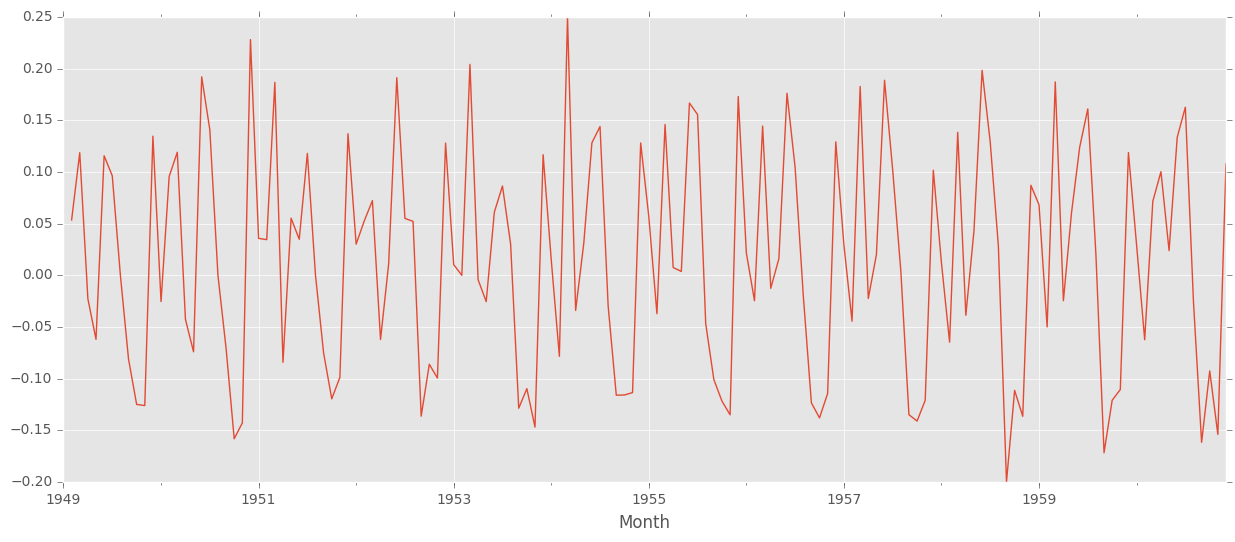

In [170]:
#show % change per timestep
apts.pct_change().plot()

In [172]:
#measure peak-to-peak or amplitude
apts['1950':'1955'].ptp()

250

In [177]:
#get Nth quantile (Benchmarking)
apts.quantile(.01)

112.86

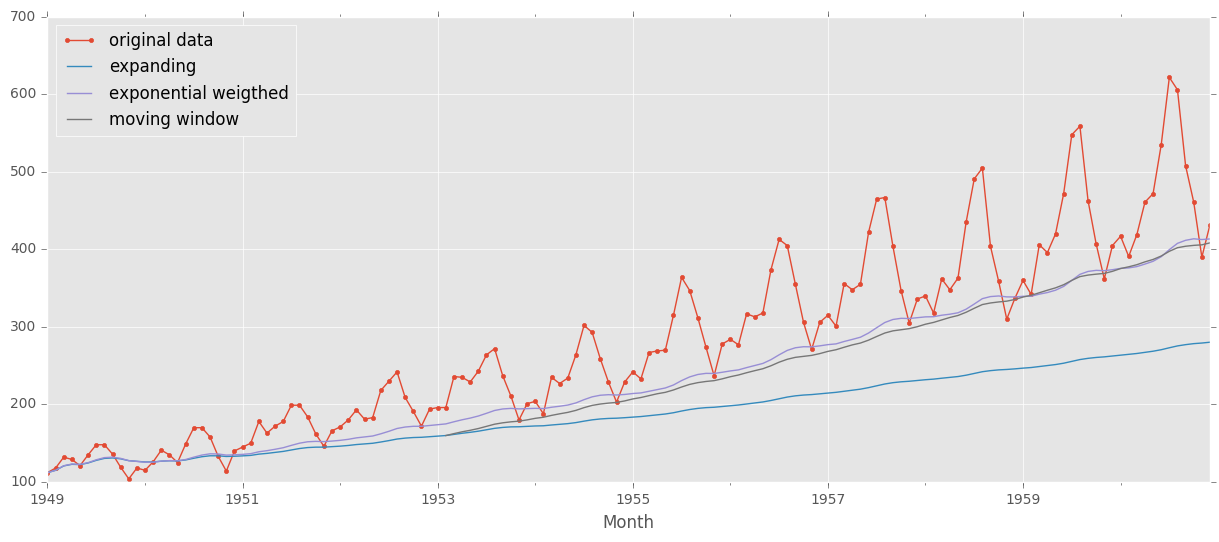

In [231]:
#comparing EWM mean with fixed moving window mean and expanding window mean
apts.plot(marker='.', label='original data')
apts.expanding().mean().plot(label='expanding')
apts.ewm(span=50).mean().plot(label='exponential weigthed')
apts.rolling(50).mean().plot(label='moving window')
plt.legend(loc='best')

## Test for stationary time series

Let's test the time series for the stationary property using the Dickey-Fuller test.
*  If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

In [225]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = ps.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print dfoutput

In [226]:
test_stationary(apts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


Ergo, our timeseries is not stationary

## Testing for White Noise using the Ljung-Box test and Box-Pierce test

The Ljung–Box test may be defined as:

$H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).<br>
$H_a$: The data are not independently distributed; they exhibit serial correlation.

$Q = n(n+2)\sum_{k=1}^{h}\frac{\rho_k^2}{n-k}$

Where:<br>
- $n$: sample size
- $\rho_k$: autocorrelation at lag $k$
- $h$: number of lags

$Q$ follows the $\chi_{(h)}^2$ distribution.

The test statistic for rejection of $H_0$ is:<br>
$Q > \chi_{1-a,h}^2$ <br>
where: <br>
$\chi_{1-a,h}^2$ is the $a$th quantile of the distribution with $h$ degrees of freedom

In [15]:
from statsmodels.sandbox.stats.diagnostic import *

degrees_of_freedom = 5
ljung_result = acorr_ljungbox(apts, lags = 5, boxpierce = True)

In [42]:
from scipy.stats import chi2
dfljung = ps.DataFrame(np.asmatrix(ljung_result).transpose(), columns=['Test statistic','p value', 'Test statistic Box-Pierce', 'p value Box-Pierce'])
dfs = np.arange(1,6,1)
q99chi = []
for df in dfs:
    q99chi.append(chi2.pdf(.99,df))
q95chi = []
for df in dfs:
    q95chi.append(chi2.pdf(.95,df))

dfljung['99th quantile chi2'] = q99chi
dfljung['95th quantile chi2'] = q95chi
dfljung

,Test statistic,p value,Test statistic Box-Pierce,p value Box-Pierce,99th quantile chi2,95th quantile chi2
0,132.141539,1.393231e-30,129.426301,5.471060e-30,0.244409,0.254541
1,245.646160,4.556318e-54,239.821208,8.384679e-53,0.304785,0.310943
2,342.674826,5.751088e-74,333.526974,5.499710e-72,0.241965,0.241814
3,427.738684,2.817731e-91,415.095056,1.522155e-88,0.150869,0.147698
4,504.796570,7.360195e-107,488.458387,2.473624e-103,0.079848,0.076575


Ergo we conclude that for all lags the time series is **not** independently varying (i.e. white noise)

## Fourier analysis of a time series

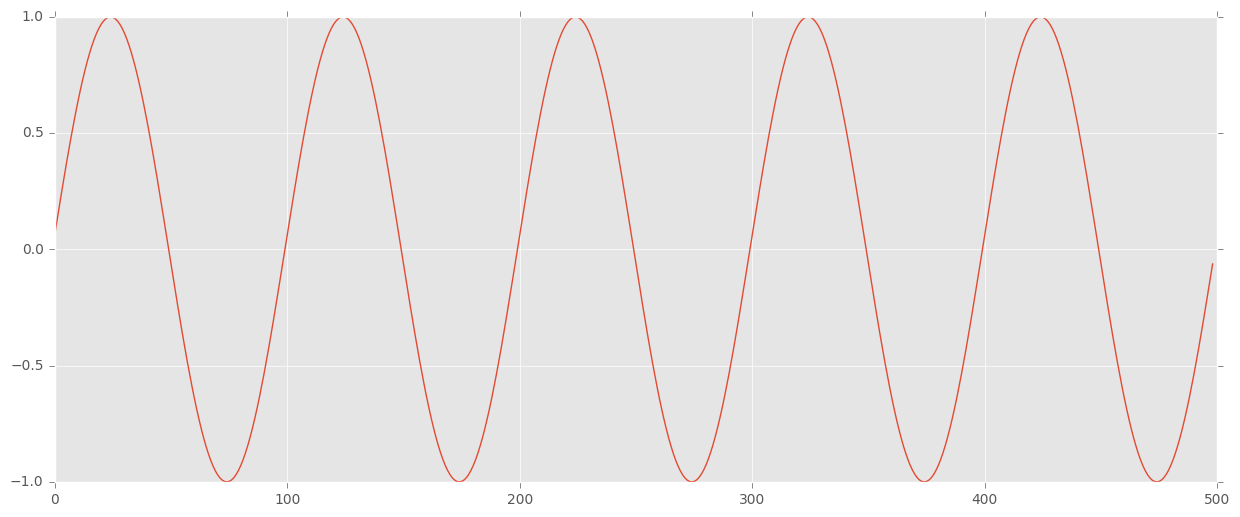

In [87]:
#from scipy.fftpack import *
from numpy import fft

#setup a sinewave with f = 5
tmpdata = ps.Series(1, index=np.arange(1,500))
arg = (tmpdata.index * np.pi)/50

tmpdata = np.sin((tmpdata.index * np.pi)/50) 

plt.plot(tmpdata)
#plt.plot(arg)

Above shows a sine series with five cycles, ergo f=5

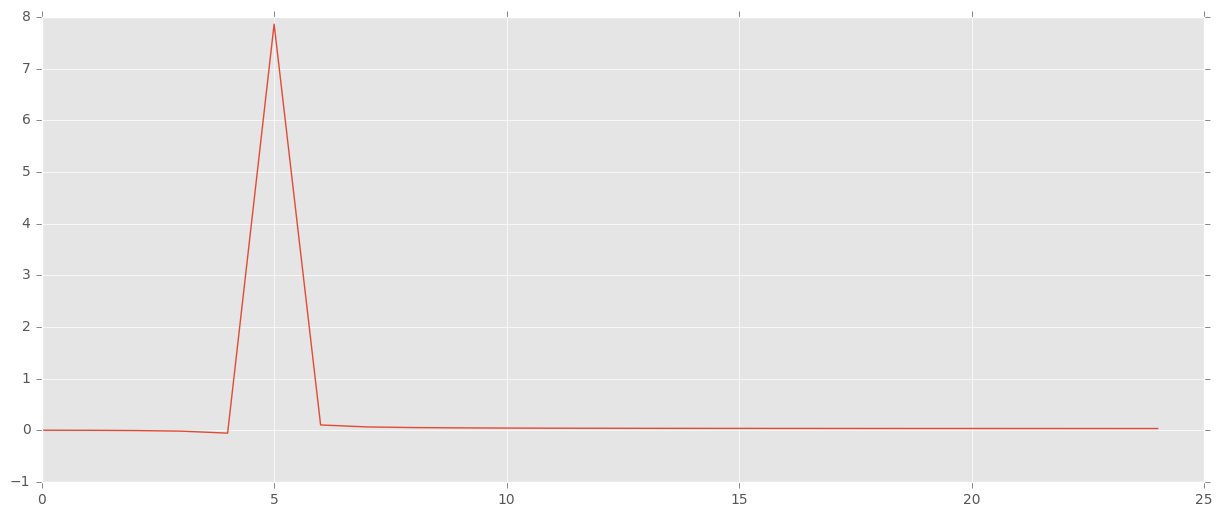

In [92]:
plt.plot(np.fft.fft(tmpdata)[0:25])

A simple call to np.fft.fft() shows that this series consists of one frequency, 5, suprise!

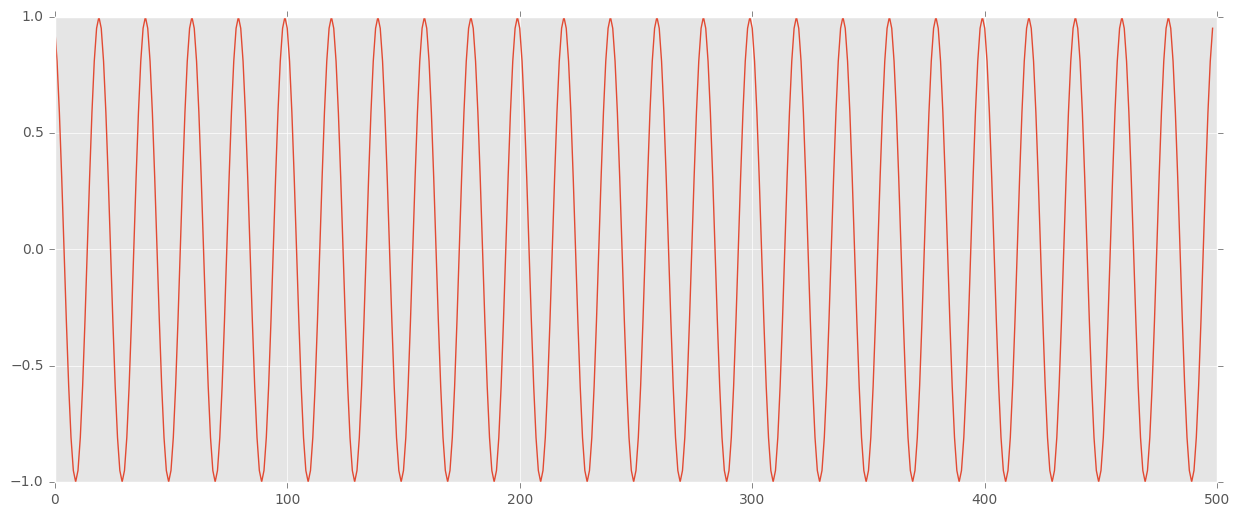

In [97]:
#Create signal with f=25
tmpdata2 = ps.Series(1, index=np.arange(1,500))
tmpdata2 = np.cos((tmpdata2.index * np.pi)/10) 
plt.plot(tmpdata2)

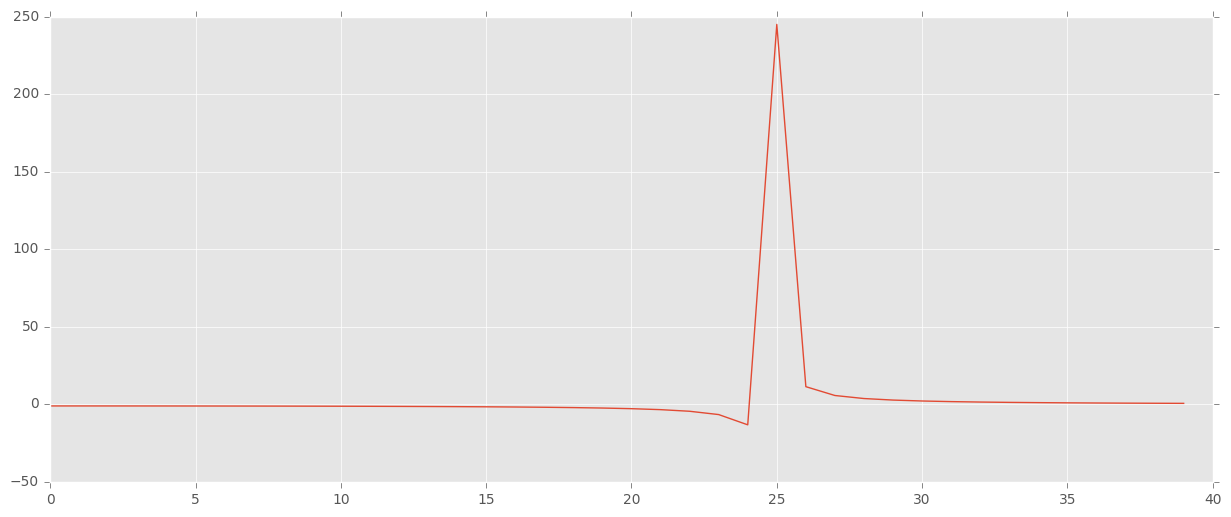

In [100]:
plt.plot(np.fft.fft(tmpdata2)[0:40])

Indeed, f=25. Note that it doesn't matter that we used the cos() function to generate the series!

Now let's combine the two series

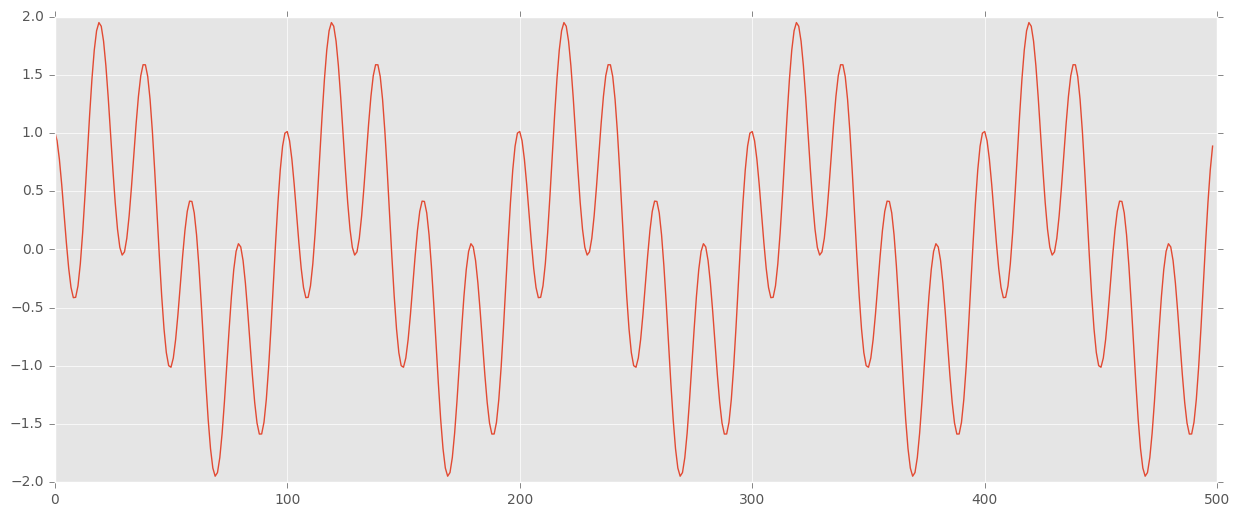

In [101]:
tmpdata3 = tmpdata + tmpdata2
plt.plot(tmpdata3)

Now let's have a look at the FFT

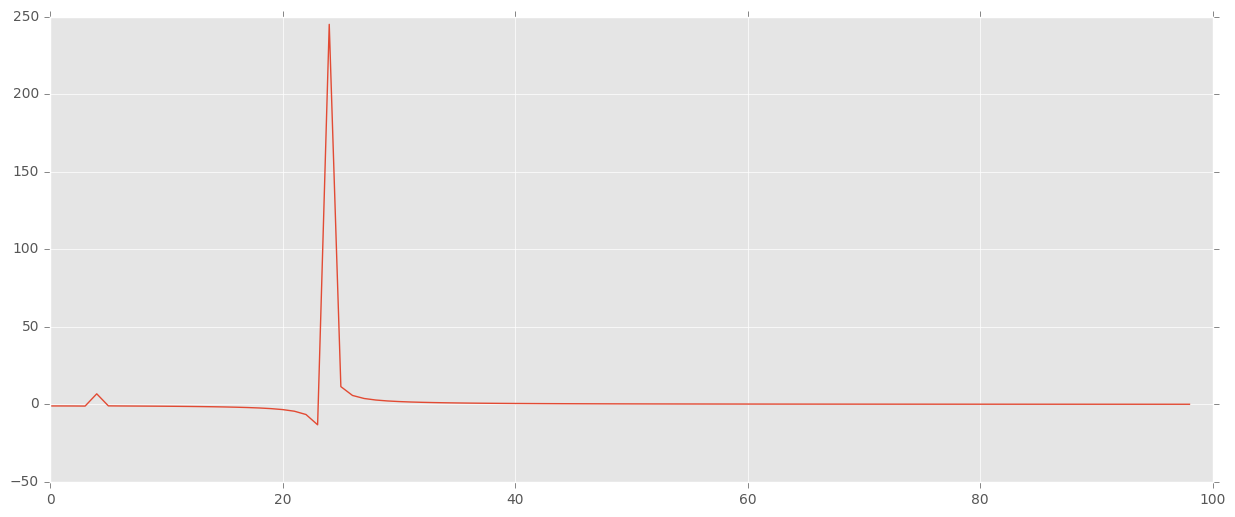

In [104]:
plt.plot(np.fft.fft(tmpdata3)[1:100])

We can now see that our signal consists of two frequencies. f=5 and f=25. The FFT returns a lower value for f=5 because the five periods contribute less that 25 periods.

Now let's have look at our airline data: Having 12 years of airline data with strong seasonality we expect at least a FFT response on f=12

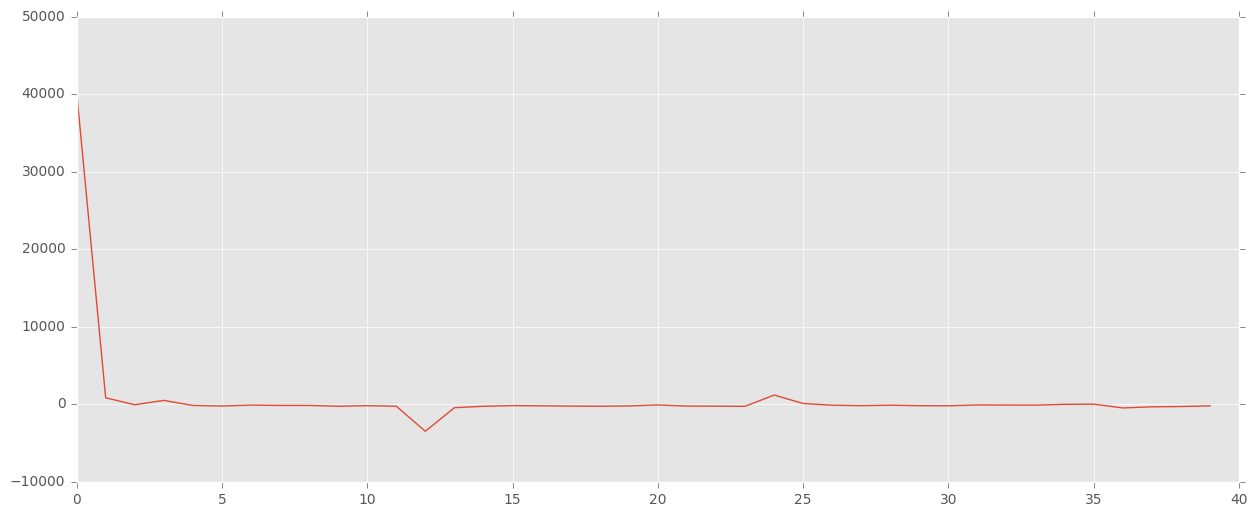

In [108]:
plt.plot(np.fft.fft(apts)[0:40])

Indeed we see a response on f=12. We also see the cycle each half year on f=24. The big peak on f=0 is simply the magnitude of the total series because we applied the FFT on a non-stationary series.

Based on the analysis result we can now try to reconstruct the series from the fouries base functions we found in our analysis. We can then use this to extend or forecast the series!

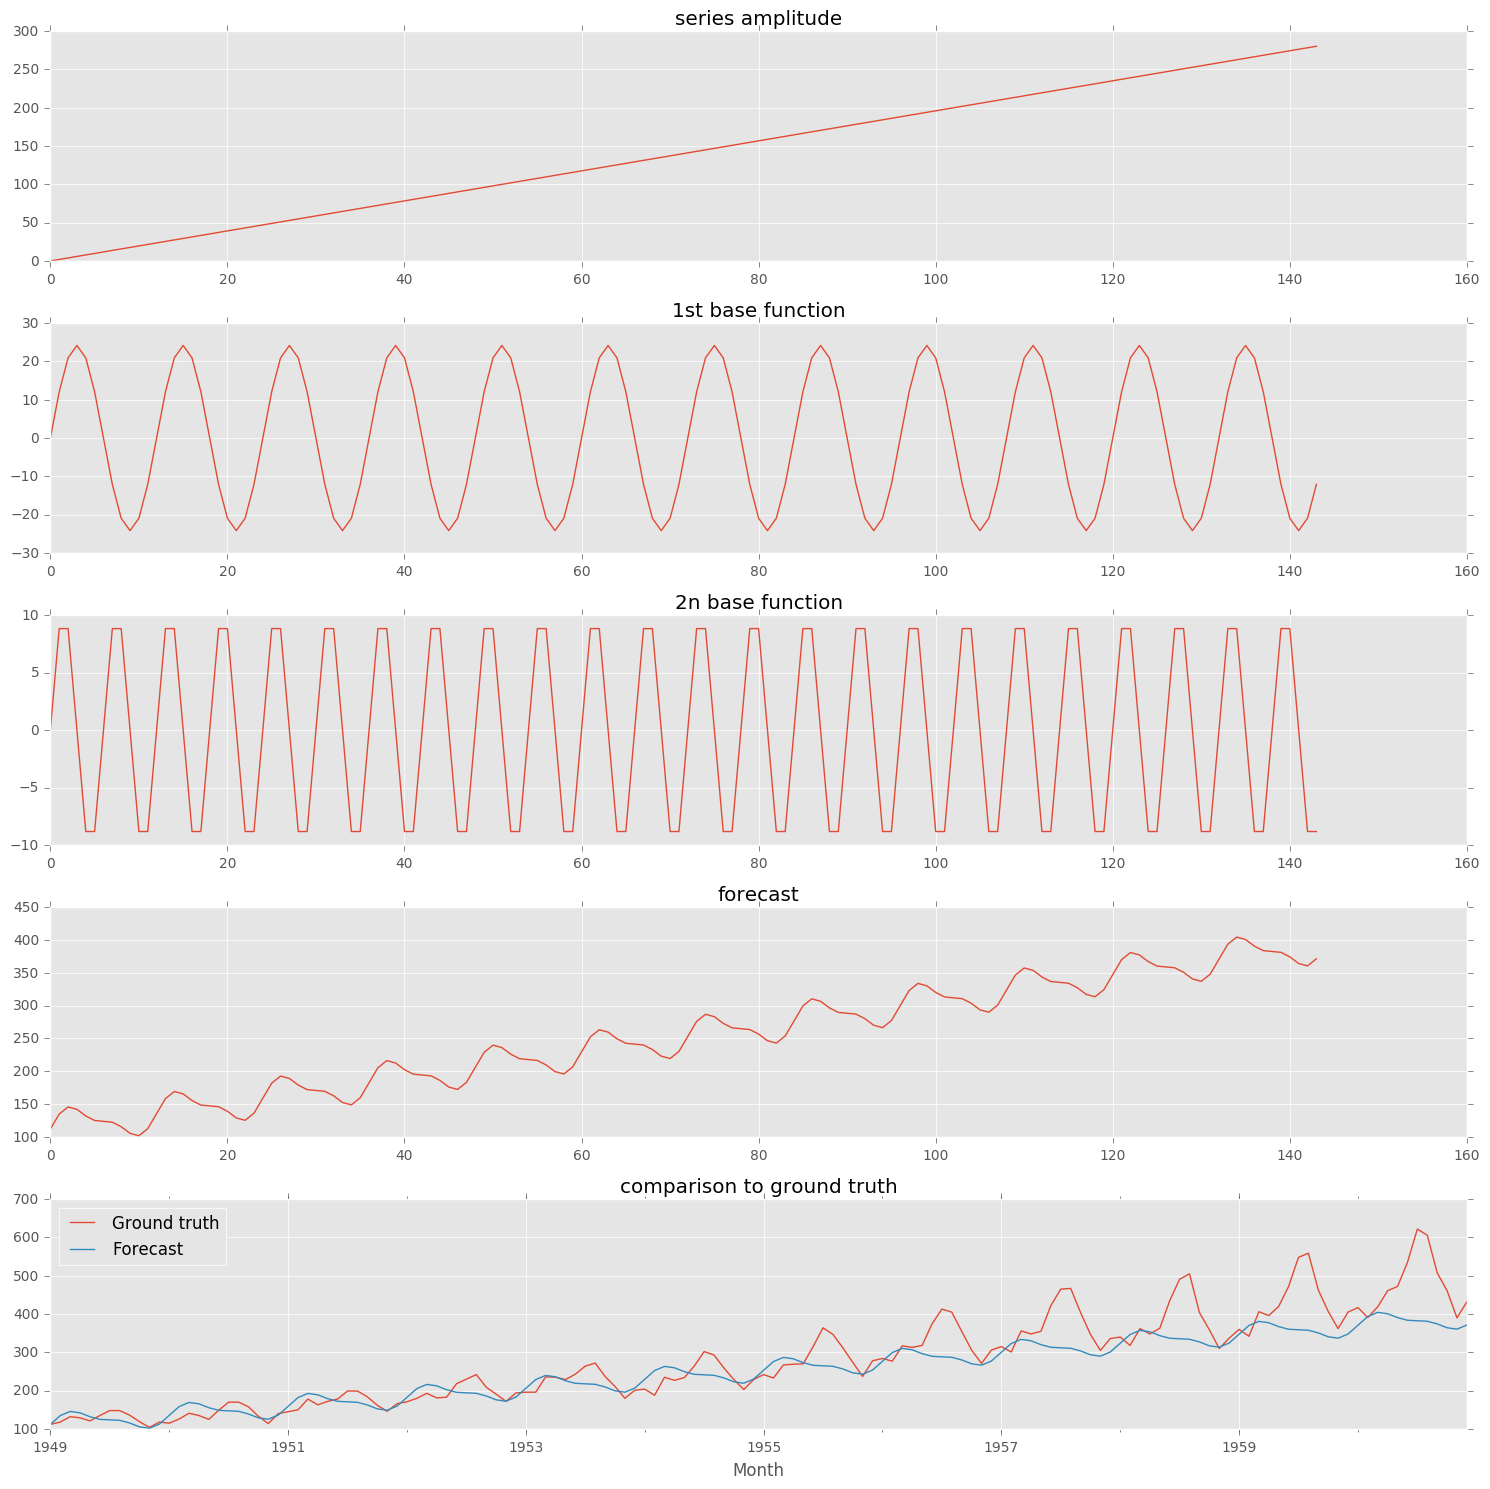

In [173]:
forecast = ps.Series(1, index=np.arange(0,len(apts)))
base12 = np.sin((forecast.index * np.pi * 2) / (len(apts)/12)) *  (np.abs(np.fft.fft(apts)[12]) / len(apts))#1st base function was at f=12
base24 = np.sin((forecast.index * np.pi * 2) / (len(apts)/24)) * (np.abs(np.fft.fft(apts)[24]) / len(apts)) #2nd base function was at f=24
f0_amplitude = np.max(np.fft.fft(apts)[0:40]) / len(apts) # f=0 was about 40000 which we divide by the contributions or N(apts) = 144
base0 = np.linspace(0,f0_amplitude, len(apts), dtype=float)

plt.figure(figsize=(15,15))
ax = plt.subplot(511)
ax.set_title("series amplitude")
plt.plot(base0)
ax = plt.subplot(512)
ax.set_title("1st base function")
plt.plot(base12)
ax = plt.subplot(513)
ax.set_title("2n base function")
plt.plot(base24)
ax = plt.subplot(514)
ax.set_title("forecast")
plt.plot(base0 + base12 + base24 + apts[0])
ax = plt.subplot(515)
ax.set_title("comparison to ground truth")
tmpdf = ps.DataFrame()
tmpdf['Ground truth'] = apts
tmpdf['Forecast'] = base0 + base12 + base24 + apts[0]
tmpdf.plot(ax=ax)
plt.tight_layout()

Comparing the original data with our forecast we can see the we are missing the increasing variation that is present in the original data. The non-stationary character of our base function is causing this error in our forecast. FFT assumes a stationary time series.

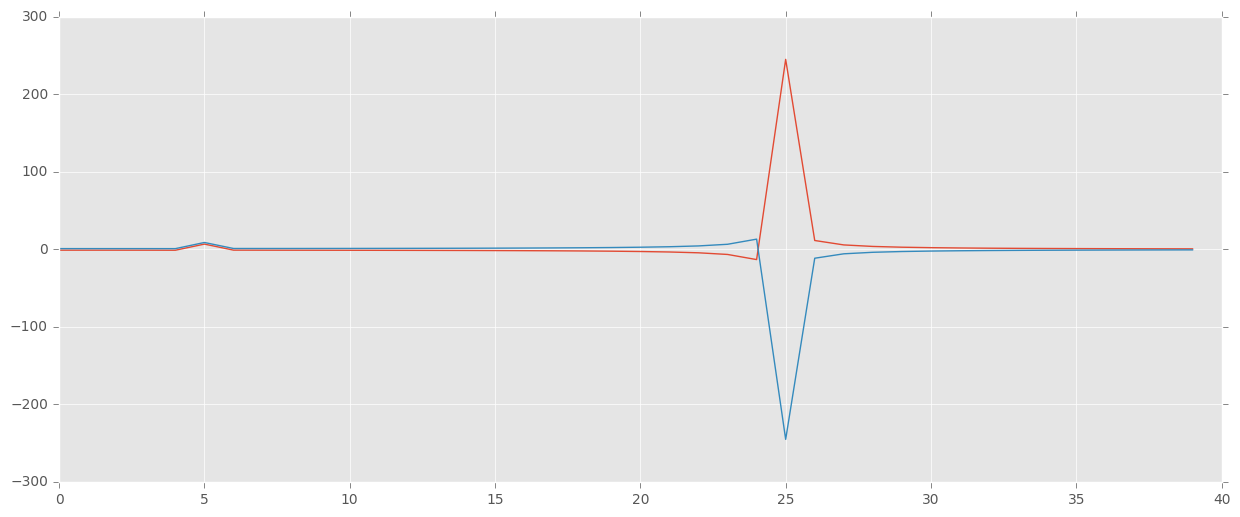

In [111]:
multidimensional_series = ps.DataFrame()
multidimensional_series['dim1'] = tmpdata
multidimensional_series['dim2'] = tmpdata2
plt.plot(np.fft.fft2(multidimensional_series)[0:40])

Above we see an alternative way of calculating the FFT for a 2-dimensional dataset. np.fft supports N-dimensional data with np.fft.fftn()

Some additional reading: <br>
have a look at: https://gist.github.com/tartakynov/83f3cd8f44208a1856ce <br>
and here : https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/ <br>
and a nice succinct example here: http://glowingpython.blogspot.nl/2011/08/how-to-plot-frequency-spectrum-with.html

## Determining a local stationary wavelet function of the time series

## Removing Trends / Detrending

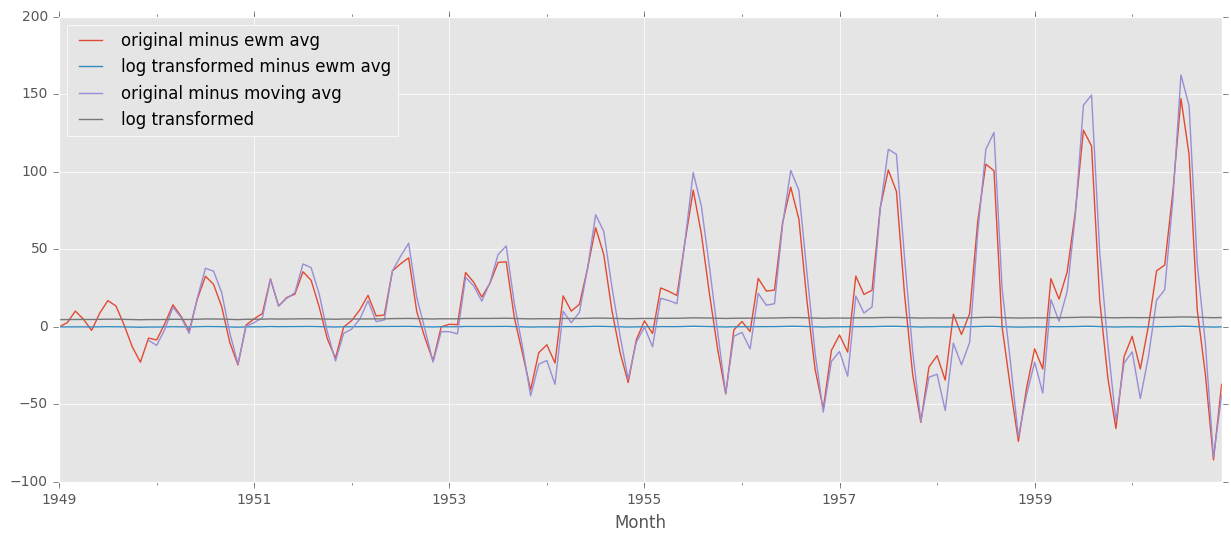

In [236]:
apts_log = np.log(apts)
apts_min_mavg = apts - apts.rolling(12).mean()
apts_min_ewm_avg = apts - apts.ewm(span=12).mean()
apts_log_min_ewm_avg = apts_log - apts_log.ewm(halflife=12).mean()
apts_min_ewm_avg.plot(label='original minus ewm avg')
apts_log_min_ewm_avg.plot(label='log transformed minus ewm avg')
apts_min_mavg.plot(label='original minus moving avg')
#apts.plot(label='original')
apts_log.plot(label='log transformed')
plt.legend(loc='best')

In [227]:
test_stationary(apts_log)

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


In [229]:
test_stationary(apts_min_mavg.dropna())

Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (5%)             -2.886151
Critical Value (1%)             -3.486535
Critical Value (10%)            -2.579896
dtype: float64


In [237]:
test_stationary(apts_log_min_ewm_avg)

Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (5%)             -2.884042
Critical Value (1%)             -3.481682
Critical Value (10%)            -2.578770
dtype: float64


A means of reducing seasonality is differencing. E.g.

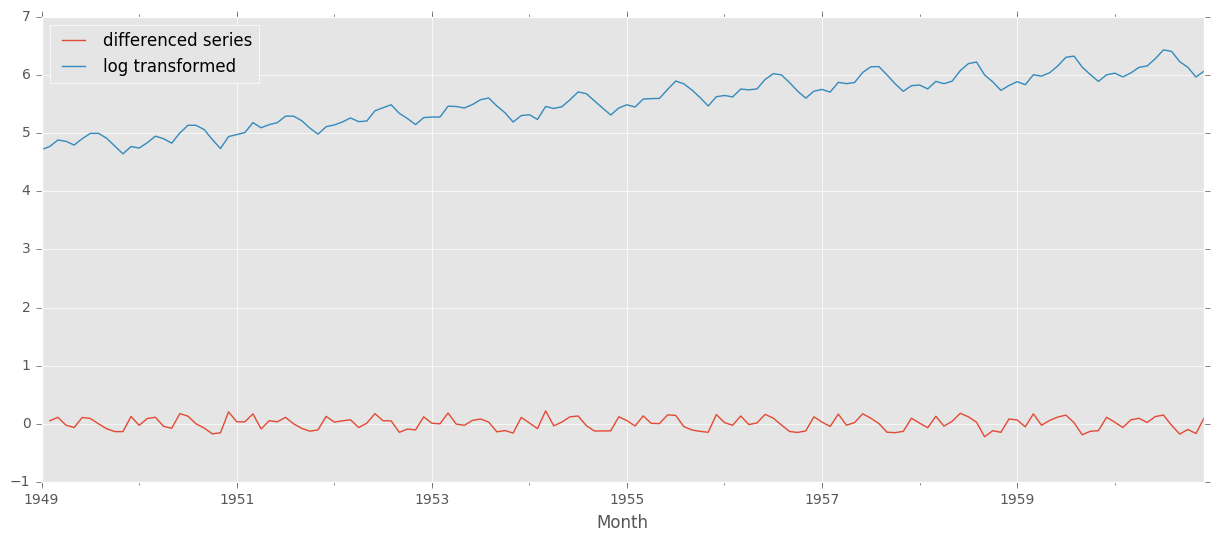

In [240]:
(apts_log - apts_log.shift()).plot(label='differenced series')
apts_log.plot(label='log transformed')
plt.legend(loc='best')

## Decomposition of a time series

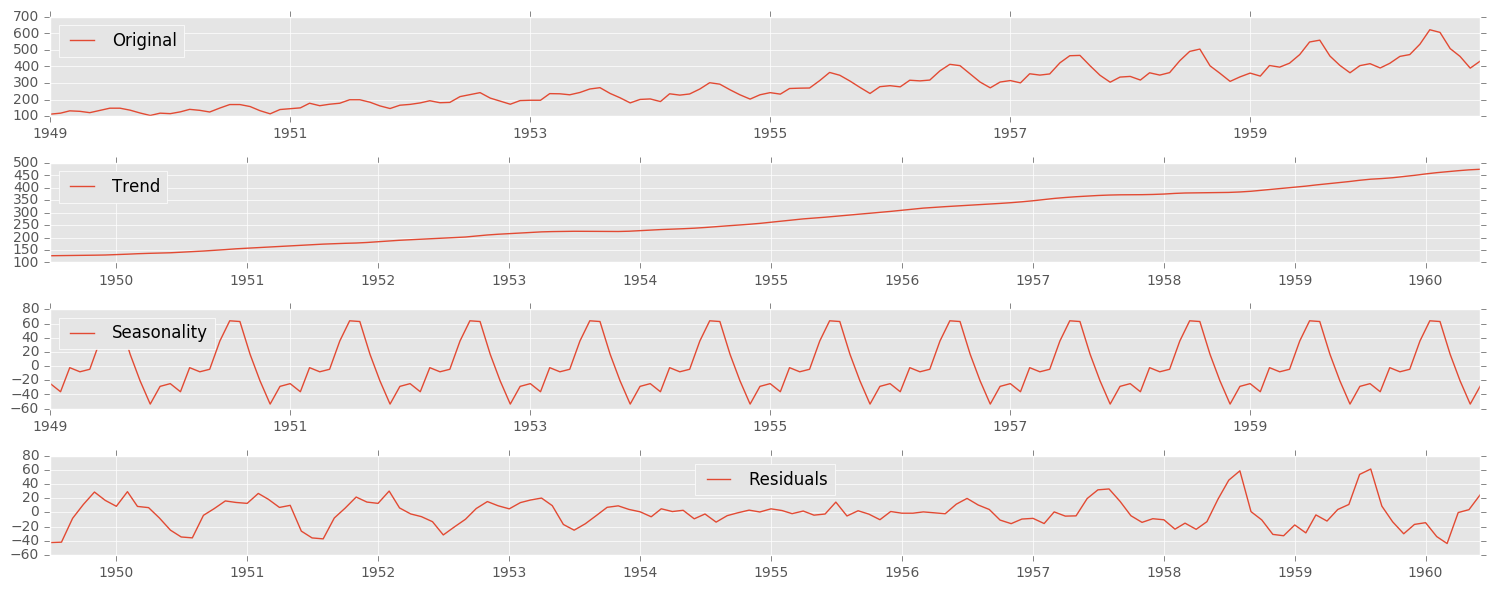

In [244]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec_ts = apts
decomposition = seasonal_decompose(dec_ts)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dec_ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Autocorrelation and Partial Autocorrelation

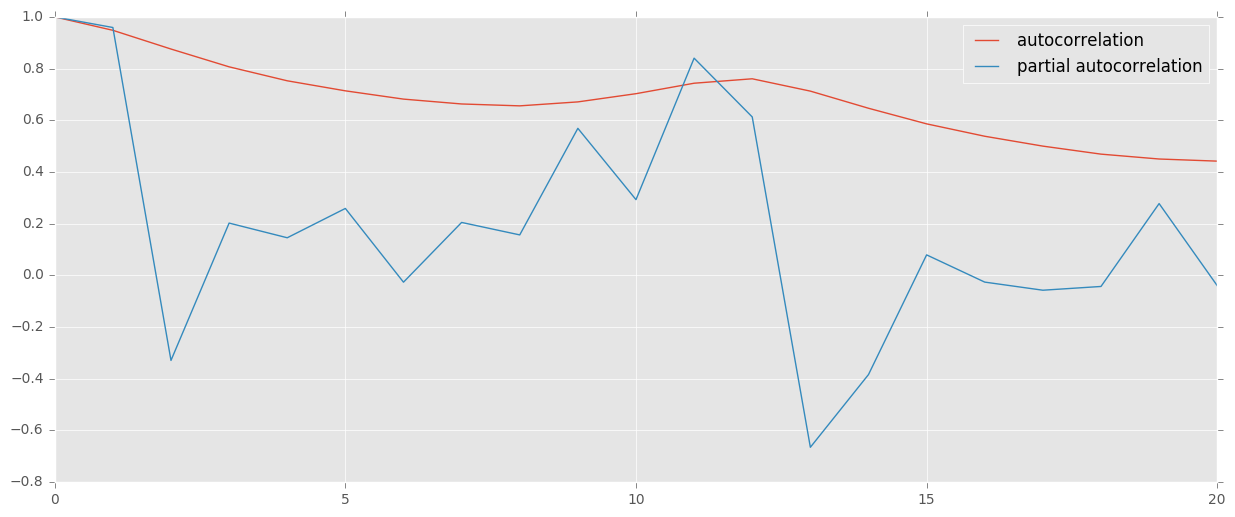

In [245]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(apts, nlags=20)
lag_pacf = pacf(apts, nlags=20, method='ols')
plt.plot(lag_acf, label='autocorrelation')
plt.plot(lag_pacf, label='partial autocorrelation')
plt.legend(loc='best')

Autocorrelation and Partial autocorrelation are commonly used to obtain P and Q values as parameters to fit an ARIMA model. <br>
See also https://github.com/aarshayj/Analytics_Vidhya/blob/master/Articles/Time_Series_Analysis/Time_Series_AirPassenger.ipynb

## Pandas Time series functionality

Pandas has extensive support for time based indexing. Below is an example of a times series (as ps.Series, with a time index). Slicing and intelligent indexing (including business hours/days/years). Time calculations are easy using various offset classes that can simply be added to a time.

In [201]:
import datetime
from pandas.tseries.offsets import *

d = datetime.datetime.now()
o = DateOffset(days=5, hours=2)
print(d)
print(d+o)

2016-10-26 23:03:45.639249
2016-11-01 01:03:45.639249


Pandas allows you to easily shift or lag a timeseries to align a series.

In [202]:
ts = ps.date_range(datetime.datetime.now(), periods=24, freq='s')
ts[1:10]

DatetimeIndex(['2016-10-26 23:03:47.428706', '2016-10-26 23:03:48.428706',
               '2016-10-26 23:03:49.428706', '2016-10-26 23:03:50.428706',
               '2016-10-26 23:03:51.428706', '2016-10-26 23:03:52.428706',
               '2016-10-26 23:03:53.428706', '2016-10-26 23:03:54.428706',
               '2016-10-26 23:03:55.428706'],
              dtype='datetime64[ns]', freq='S')

In [203]:
ts[1:10].shift(5)

DatetimeIndex(['2016-10-26 23:03:52.428706', '2016-10-26 23:03:53.428706',
               '2016-10-26 23:03:54.428706', '2016-10-26 23:03:55.428706',
               '2016-10-26 23:03:56.428706', '2016-10-26 23:03:57.428706',
               '2016-10-26 23:03:58.428706', '2016-10-26 23:03:59.428706',
               '2016-10-26 23:04:00.428706'],
              dtype='datetime64[ns]', freq='S')

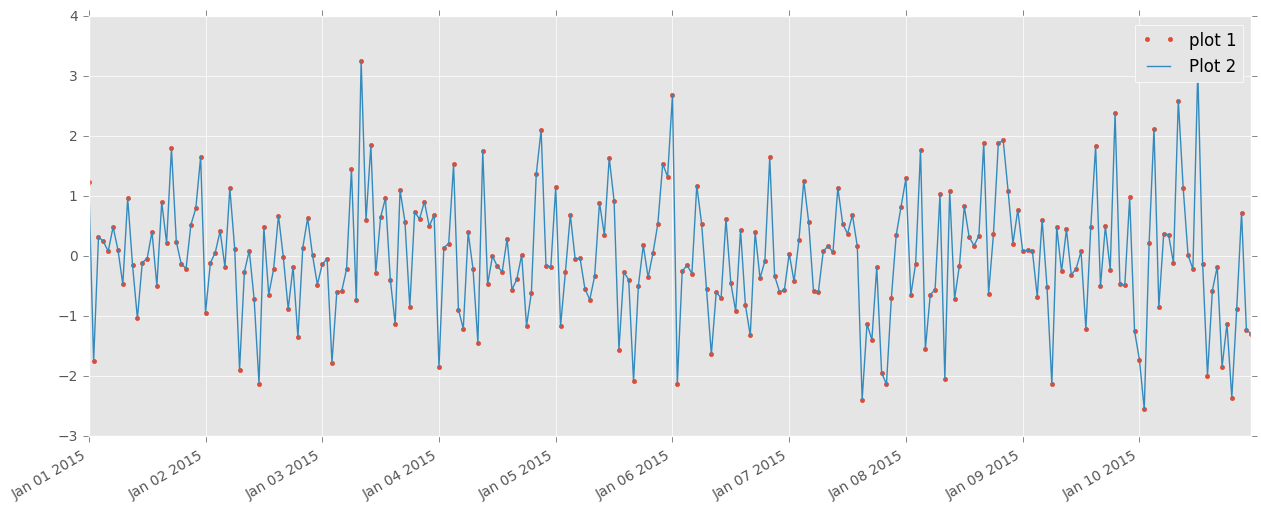

In [204]:
import matplotlib.pylab as plt

#Generate data
rng = ps.date_range('1/1/2015', periods=240, freq='H')
ts = ps.Series(np.random.randn(len(rng)), index=rng)

#to generated a range of business days you can use ps.bdate_range()

#plot values (both xy and lineplot)
plt.plot(ts, '.', label='plot 1')
ax = ts.plot(label='Plot 2')
ax.legend()

In [205]:
#Change the frequency of a time series
# to 45 minute frequency and forward fill
converted = ts.asfreq('15Min', 'pad') 
converted[1:10]

2015-01-01 00:15:00    1.235314
2015-01-01 00:30:00    1.235314
2015-01-01 00:45:00    1.235314
2015-01-01 01:00:00   -1.748096
2015-01-01 01:15:00   -1.748096
2015-01-01 01:30:00   -1.748096
2015-01-01 01:45:00   -1.748096
2015-01-01 02:00:00    0.324323
2015-01-01 02:15:00    0.324323
Freq: 15T, dtype: float64

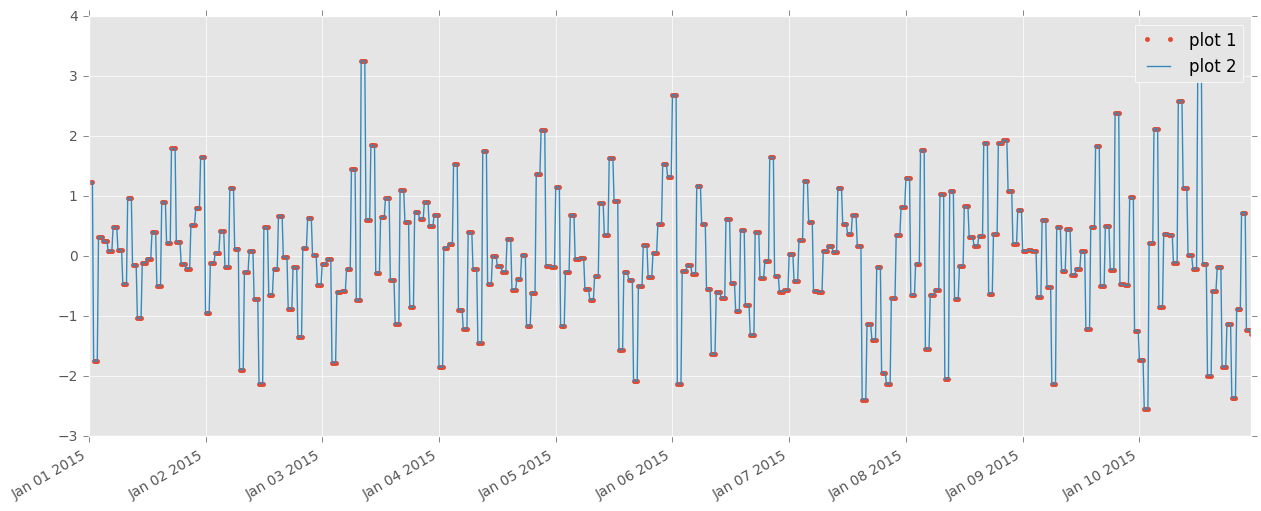

In [206]:
plt.plot(converted, '.', label='plot 1')
ax = converted.plot(label='plot 2')
ax.legend()

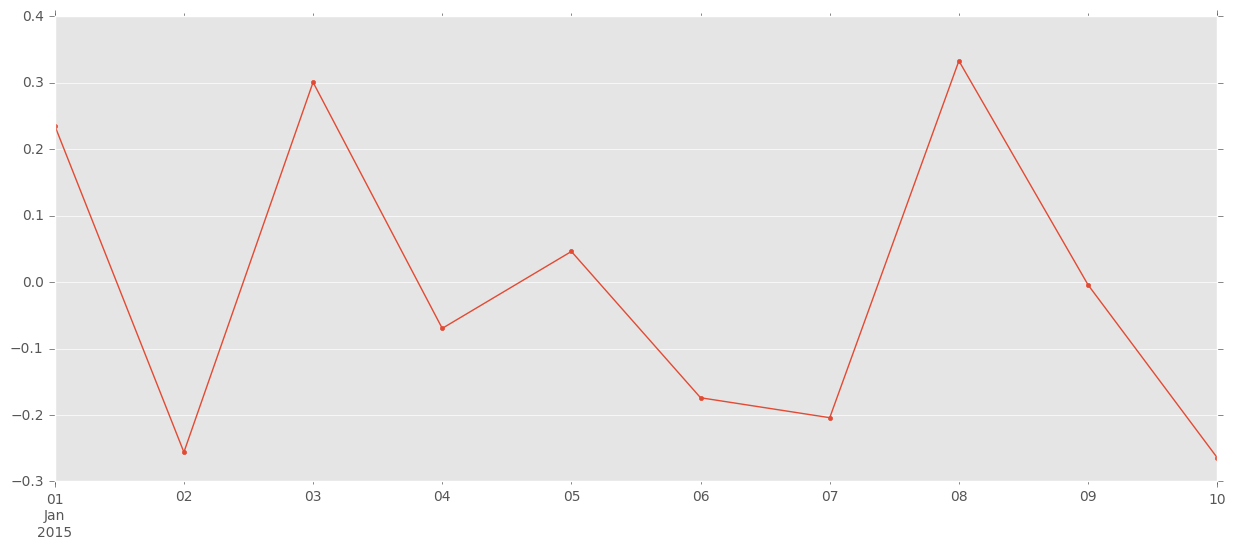

In [207]:
#resampling
# Daily means
daily = ts.resample('D').mean()
daily.plot(marker='.')

## Comparison of ARIMA vs RNN based forecasting

Topics:
* [PyFlux](http://www.pyflux.com)
* leveraging CUDA in TS analysis
* Exploring relationships between time series
* more generally, forecasting only from a single series seems foolhardy. Usually you are looking at the expression of behavior of a complex system. For which it is likely you have more information to put into your model. So how can you effectively model everything you know about that system. You have a time series but you may also have static variables, timestamped data, correlating variables, etc. etc. I don't see much work being done on more complex models like this.
* Bayesian inference on event influence on time series
* Feature extraction from time series (for anomaly detection)
* Classification of timeseries (pattern recognition), this implies you can determine time-slices to classify
* [Wavelets](https://www.researchgate.net/profile/Jean_Sanderson/publication/227464409_Measuring_dependence_between_non-stationary_time_series_using_the_locally_stationary_wavelet_model/links/5463780a0cf2c0c6aec4bffe.pdf?origin=publication_detail)
* [more wavelets](http://biostochastics.slu.se/publikationer/dokument/Report2007_2.pdf)
* [still more wavelets](http://stats.lse.ac.uk/fryzlewicz/flsw/pred_lsw.pdf)
* [Heteroscedasticity](https://www.researchgate.net/profile/Jean_Sanderson/publication/227464409_Measuring_dependence_between_non-stationary_time_series_using_the_locally_stationary_wavelet_model/links/5463780a0cf2c0c6aec4bffe.pdf?origin=publication_detail)
* [Multivariate adaptive regression splines](https://www.wikiwand.com/en/Multivariate_adaptive_regression_splines)
* [Autoregressive conditional heteroskedasticity](https://www.wikiwand.com/en/Autoregressive_conditional_heteroskedasticity)
* [hybrid ARIMA-GARCH](http://ijbds.usb.ac.ir/pdf_2198_4150a14b626373be361539db9796e1de.html)
* [Vitaly Kuznetzov](http://cims.nyu.edu/~vitaly/)
* [Learning theory and algorithms for forecasting non-stationary time series.](http://www.cs.nyu.edu/~mohri/pub/ts.pdf)
* [Time series prediction and online learning.](http://www.cs.nyu.edu/~mohri/pub/otbts.pdf)
* RNN topologies
* RBM for time series
* Graphical models
* Deep Temporal Sigmoid Belief Networks
* [Minimax model for time series prediction](https://papers.nips.cc/paper/5730-minimax-time-series-prediction.pdf)
* [Learning Stationary Time Series using Gaussian Processes with Nonparametric Kernels](https://papers.nips.cc/paper/5772-learning-stationary-time-series-using-gaussian-processes-with-nonparametric-kernels.pdf)
* [multivariate time series](https://drive.google.com/file/d/0Bx7depbNYaFIa0NDZkVrcTRCMVlwamlXelFocURSdWNoWGZZ/view)
* [Autoregressive Kernels](http://arxiv.org/abs/1101.0673)
* [Consistent Algorithms for Clustering Time Series](http://www.jmlr.org/papers/volume17/khaleghi16a/khaleghi16a.pdf)
* [Temporal Regularized Matrix Factorization for High-dimensional Time Series Prediction](http://www.cs.utexas.edu/~rofuyu/papers/tr-mf-nips.pdf)
* [Granger Causality Analysis in Irregular Time Series](http://www-bcf.usc.edu/~liu32/paper/sdm2012_irr.pdf)
* [Toward Learning and Mining from Uncertain Time-Series Data for Activity Prediction](http://eecs.wsu.edu/~bminor/KDD_MiLeTS.pdf)
* [Probabilistic time series forecasting with boosted additive models: an application to smart meter data](http://www.souhaib-bentaieb.com/papers/sigkdd-milets-probabilistic-forecasting.pdf)
* [Extracting Predictive Information from Heterogeneous Data Streams using Gaussian Processes.](http://arxiv.org/abs/1603.06202)
* [forecasting housing prices](https://github.com/rsvp/fecon235/blob/master/nb/fred-housing.ipynb#dt_2016-02-10_133519)
* [forecasting futures and FED rate](https://github.com/rsvp/fecon235/blob/master/nb/qdl-libor-fed-funds.ipynb#dt_2015-11-02_200321)
* [Derivatives analysis](https://github.com/rsvp/fecon235/blob/master/nb/qdl-COTR-positions.ipynb#dt_2015-11-25_103609)
* [bonds, equity and gold forecasting using geometric mean](https://github.com/rsvp/fecon235/blob/master/nb/fred-georeturns.ipynb#dt_2015-12-16_163517)
* [fecon library](https://github.com/rsvp/fecon235#dt_2015-08-01_094628)

Further inspiration:
https://cran.r-project.org/web/views/TimeSeries.html
http://biostochastics.slu.se/publikationer/dokument/Report2007_2.pdf